<a href="https://colab.research.google.com/github/HailtheWhale/ImageSegmentation/blob/main/Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Creation/ Manipulation

In [ ]:
'''
Code meant to generate more
randomized images for data. Randomization
is based on seed use. Marked randomized
images correspond to raw images.
'''

# Data Augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os

# Initializing Datagen Parameters
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    fill_mode='wrap'
)

# Initializing Directory Paths
dir_raw = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Test_Images/Raw_Test_Images' # raw irectory
dir_marked = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Test_Images/Marked_Test_Images' #marked directory
dir_base = [dir_raw, dir_marked]

rand_img_count = 0
dup_cnt = 10

# Looping through both directories
for dir in dir_base:
  # Looping thru dir
  print(f'The Directory is: {dir}') # Directory working on

  for imagename in os.listdir(dir):
    print(f'\nThe image is {imagename}')
    img_path = os.path.join(dir, imagename)

    img = load_img(img_path) # Loading image
    x = img_to_array(img) # Converting image to numpy array
    x = x.reshape((1,) + x.shape) # reshaping image
    # Dimensions of image. (1,480,640,3) for all. 480,640 = dimensions.
    # 3 = RGB. 1 = img batch size.
    print(f'The shape is {x.shape}')

  ## Removing .png ending from image name
    modified_image_prefix = list(imagename) # Casting string to list
    for num in range(4):
      modified_image_prefix.pop() # removing last 4 letters
    joined_prefix = ''.join(modified_image_prefix) # rejoining

  ## Setting Image Save Directories
    if dir == dir_raw:
      save_path = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Raw_Randomized_Images'
    else:
      save_path = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Marked_Randomized_Images'

  ## Applying randomizations
    i = 0 # initializing counter. DETERMINES randomized count for each image in filepath
    for batch in datagen.flow(
          x,
          batch_size=1,
          seed=42,
          save_to_dir= save_path,
          save_prefix = joined_prefix,
          save_format = 'jpeg'):
      i += 1
      print(f"Generated {i} image(s).")
      rand_img_count = rand_img_count + 1 # updating image counter
      if i >= dup_cnt:
        break

  # Spacing Image info
  print('\n########')

print(f'\n{rand_img_count/2} raw images generated.')
print(f'{rand_img_count/2} marked images generated.')

In [ ]:
'''
Making the masks
'''
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Directories
marked_rand_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Test_Images/Marked_Test_Images'

image_cnt = 0

# Randomized img index selection
# Loops thru all images
for image in range(0, len(os.listdir(marked_rand_dir))):

  image_cnt += 1
  print(f'\nImage {image_cnt}')

  # Selecting samples from folder
  marked_image_list = os.listdir(marked_rand_dir)
  marked_image = marked_image_list[image]
  print(f'  The name is {marked_image}')

  # Making sample loads ready
  marked_img_path = os.path.join(marked_rand_dir, marked_image)

  ##################
  # Exactracting needed values from images
  ##################

  # Converting marked image into flattened
  # list of RGB values.
  marked_img = Image.open(marked_img_path, 'r')
  marked_pix_val = list(marked_img.getdata())

  ###################
  # Forming Data List
  ###################

  # Forming Blank Data list
  data_list = [[0,0,0]]
  for index in range(1,len(marked_pix_val)):
    data_list.append([0,0,0])

  # Updating Flattened Index Values in data_list
  # Placing X and Y Coordinates
  j = -1
  for Y in range(0,int(len(data_list)/640)):
    j += 1
    i = -1
    for X in range(0,int(len(data_list)/480)):
      i += 1
      index = i + j*640
      data_list[index][0] = X
      data_list[index][1] = Y

  ######### Label Extraction and Application via Marked Images

  # Updating labels in data_list
  i = -1
  for R,G,B in marked_pix_val:
    i+=1
    if R >= 250:
      data_list[i][2] = 255 # True Defect

  # Blank Mask Initialization
  mask = np.zeros(shape=(480,640))

  # Updating Mask

  for pixel in range(0, len(data_list)):
    i = data_list[pixel][0]
    j = data_list[pixel][1]
    mask[j][i] = data_list[pixel][2]

  # Converting array to image.
  mask_data = Image.fromarray(mask)
  mask_data = mask_data.convert('RGB')

  # Getting Image names.
  # Pulling marked_image
  dir = "/content/drive/MyDrive/Glass_Fibre_CV_ML/Test_Images/Mask_Test_Images"
  mask_path = os.path.join(dir, marked_image)

  # Saving
  mask_data.save(mask_path)


(307200, 3)
(480, 640, 3)


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


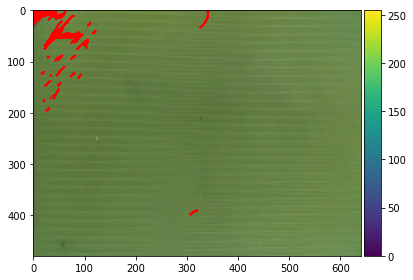

In [ ]:
import tensorflow as tf
import os
import numpy as np
import random

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

np_pix = np.asarray(marked_pix_val)
print(np_pix.shape)
np_pix = np_pix.reshape(480,640,3)
print(np_pix.shape)
imshow(np_pix)

In [ ]:
'''
Making the segmented images. x4/img
'''
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import time

# Directories
raw_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Test_Images/Raw_Test_Images'
marked_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Test_Images/Marked_Test_Images'
mask_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Test_Images/Mask_Test_Images'

image_cnt = 0

# Randomized img index selection
# Loops thru all images
for image in range(0, len(os.listdir(raw_dir))):

  image_cnt += 1
  print(f'\nImage {image_cnt}')

  for img_type in ('raw','marked','masked'):

    # Copying appropriate directory
    if img_type == 'raw':
      dir = raw_dir
    elif img_type == 'marked':
      dir = marked_dir
    elif img_type == 'masked':
      dir = mask_dir

    # Selecting samples from folders
    image_list = os.listdir(dir)
    current_image = image_list[image]
    print(current_image)
    print(f'  The {img_type} image is {current_image}')

    # Making sample loads ready
    img_path = os.path.join(dir, current_image)

    ##################
    # Exactracting needed values from images
    ##################

    # Converting marked image into flattened
    # list of RGB values.
    read_img = Image.open(img_path, 'r')
    pix_vals = list(read_img.getdata())

    # adjusting base pixel values
    np_pixs = np.asarray(pix_vals)
    #print(np_pixs.shape)
    np_pixs = np_pixs.reshape(480,640,3)
    #print(np_pixs.shape)
    #imshow(np_pixs)

    # Creating & saving the 4 sectioned images
    for section in range(0,4):

      #print(section)
      # Blank Template
      img = np.zeros((240,320,3), dtype=np.uint8)

      # To determine which part of the base img to copy
      if section == 0: # Top left
        img_cover = np_pixs[0:240,0:320]
        #print("Img 1 Ran")
      elif section == 1: # Top Right
        img_cover = np_pixs[0:240,320:640]
        #print("Img 2 Ran")
      elif section == 2: # Bottom Left
        img_cover = np_pixs[240:480,0:320]
        #print("Img 3 Ran")
      elif section == 3: # Bottom Right
        img_cover = np_pixs[240:480,320:640]
        #print("Img 4 Ran")
      else:
        print("ERROR!!!!")

      # Copying img values
      img[:,:,:] = img_cover

      # Prepping data
      data = Image.fromarray(img)

      # Setting up save path and img names
      # Choosing folder
      if img_type == 'raw':
        parent_folder = 'v3_raw/'
      elif img_type == 'marked':
        parent_folder = 'v3_marked/'
      elif img_type == 'masked':
        parent_folder = 'v3_mask/'

      save_data_path = "/content/drive/MyDrive/Glass_Fibre_CV_ML/ML/uNet_models/Version 3.0/Rand_v3/" + parent_folder
      save_data_path = save_data_path + current_image
      save_data_path = save_data_path[0:(len(save_data_path)-3)]
      save_data_path = save_data_path + str(section+1) + "of4" + ".jpeg"

      # Pausing to ensure files save
      time.sleep(3)
      data.save(save_data_path)

In [ ]:
for img_type in ('raw','marked','masked'):
  print(img_type)
for img in range(0,3):
  print(img)

raw
marked
masked
0
1
2


# Backup Data

In [ ]:
'''
This code is meant to backup and clear out the randomized
images generated below.
Found in Backup_Images
'''

import os
import shutil
from datetime import datetime

############ Moving Old Folders

# Getting Folder Paths
raw_src_path = "/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Raw_Randomized_Images"
marked_src_path = "/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Marked_Randomized_Images"
mask_src_path="/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Masks"

backup_dst_path = "/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Backup_Images"

# Moving Folders to Backup Folder
shutil.move(raw_src_path, backup_dst_path)
shutil.move(marked_src_path, backup_dst_path)
shutil.move(mask_src_path, backup_dst_path)

############ Renaming the Moved Folders

# Getting Date and time
dt_string = datetime.now()
dt_string = dt_string.strftime("%H:%M:%S %b %d %Y")

# Printing time stamp on associated folders
# Raw
raw_folder_name = "/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Backup_Images/Raw_Randomized_Images"
raw_new_folder_name = str(dt_string) + " " + "Raw_Randomized_Images"
raw_new_folder_name = os.path.join(backup_dst_path, raw_new_folder_name)
os.rename(raw_folder_name, raw_new_folder_name)

# Marked
marked_folder_name = "/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Backup_Images/Marked_Randomized_Images"
marked_new_folder_name = str(dt_string) + " " + "Marked_Randomized_Images"
marked_new_folder_name = os.path.join(backup_dst_path, marked_new_folder_name)
os.rename(marked_folder_name, marked_new_folder_name)

# Masks
masks_folder_name = "/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Backup_Images/Masks"
masks_new_folder_name = str(dt_string) + " " + "Masks"
masks_new_folder_name = os.path.join(backup_dst_path, masks_new_folder_name)
os.rename(masks_folder_name, masks_new_folder_name)

############ Making new files to replace the old ones
# Directory / File to be made
raw_file_name = "Raw_Randomized_Images"
marked_file_name = "Marked_Randomized_Images"
masks_file_name="Masks"

# File path the File will be made in
parent_folder = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images'

# Combined path of new folder
new_raw_folder = os.path.join(parent_folder, raw_file_name)
new_random_folder = os.path.join(parent_folder, marked_file_name)
new_masks_folder = os.path.join(parent_folder, masks_file_name)


# Making new folder
os.mkdir(new_raw_folder)
os.mkdir(new_random_folder)
os.mkdir(new_masks_folder)


print("The folder '% s' has been cleared. \nThe old one can be found in Backup Images with it's timestamp.\n" % new_raw_folder)
print("The folder '% s' has been cleared. \nThe old one can be found in Backup Images with it's timestamp.\n" % new_random_folder)
print("The folder '% s' has been cleared. \nThe old one can be found in Backup Images with it's timestamp.\n" % new_masks_folder)


The folder '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Raw_Randomized_Images' has been cleared. 
The old one can be found in Backup Images with it's timestamp.

The folder '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Marked_Randomized_Images' has been cleared. 
The old one can be found in Backup Images with it's timestamp.

The folder '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Masks' has been cleared. 
The old one can be found in Backup Images with it's timestamp.



# Testing


In [ ]:
'''
This code is meant to test
marked data extraction, and
determine which channel from the
RGB image would give the marked data
index based on an easily seen threshold value.
Raw data is also extracted for comparison.
'''

import os
from PIL import Image

img_index = 3 # Selects the img to test

raw_rand_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Raw_Randomized_Images'
marked_rand_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Marked_Randomized_Images'

# Selecting samples from folder
raw_image = os.listdir(raw_rand_dir)
raw_image = raw_image[img_index]
print(f'The raw image is {raw_image}')

marked_image = os.listdir(marked_rand_dir)
marked_image = marked_image[img_index]
print(f'The marked image is {marked_image}')

print(f'\nThe selected random image index is {img_index}')

# Making sample loads ready
raw_img_path = os.path.join(raw_rand_dir, raw_image)
marked_img_path = os.path.join(marked_rand_dir, marked_image)

######### Marked Image Test

# Getting RGB pixel values for marked image.
# Tuple position correspond to
# R, G, and B channels respectively
marked_img = Image.open(marked_img_path, 'r')
marked_pix_val = list(marked_img.getdata())
print(f'\nThe dimensions for the marked tuple are {marked_pix_val[0]}') # For demonstration

# Creating empty lists. If the value is above the given
# threshold, the list will be appended with that tuple.
# The list that has the greatest length will be used
# to extract the marked coordinates

list_R = []
list_G = []
list_B = []
threshold = 254

for R,G,B in marked_pix_val:
  if R >= threshold:
    list_R.append(R)
  if G >= threshold:
    list_G.append(G)
  if B >= threshold:
    list_B.append(B)
  else:
    pass

print('\nMarked Channel Test')
print('Values from the channel threshold test are:')
print(f'Red: {len(list_R)}')
print(f'Green: {len(list_G)}')
print(f'Blue: {len(list_B)}')
print(f'The threshold value was: {threshold}')

########## Raw Image Test

# Getting RGB pixel values for Raw image.
# Tuple position correspond to
# R, G, and B channels respectively
raw_img = Image.open(raw_img_path, 'r')
raw_pix_val = list(raw_img.getdata())
print(f'\nThe dimensions for the raw tuple are {raw_pix_val[0]}') # For demonstration

# Creating empty lists. If the value is above the given
# threshold, the list will be appended with that value.
# The list that has the greatest length will be used
# to extract the marked coordinates.

list_R = []
list_G = []
list_B = []
threshold = 254

for R,G,B in raw_pix_val:
  if R >= threshold:
    list_R.append(R)
  if G >= threshold:
    list_G.append(G)
  if B >= threshold:
    list_B.append(B)
  else:
    pass
print('\nRaw Channel Test')
print('Values from the channel threshold test are:')
print(f'Red: {len(list_R)}')
print(f'Green: {len(list_G)}')
print(f'Blue: {len(list_B)}')
print(f'The threshold value was: {threshold}')

In [ ]:
'''
This code is just to find image dimensions
'''
from keras.preprocessing.image import img_to_array, load_img

img_index = 3


# Raw Image
raw_rand_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Raw_Randomized_Images'
raw_image = os.listdir(raw_rand_dir)
raw_image = raw_image[img_index]
raw_img_path = os.path.join(raw_rand_dir, raw_image)
raw_img = Image.open(raw_img_path, 'r')
raw_pix_val = list(raw_img.getdata())

# Marked Image
marked_rand_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Marked_Randomized_Images'
marked_image = os.listdir(marked_rand_dir)
marked_image = marked_image[img_index]
marked_img_path = os.path.join(marked_rand_dir, marked_image)
marked_img = Image.open(marked_img_path, 'r')
marked_pix_val = list(marked_img.getdata())


print("Pixels in Image:", len(marked_pix_val))
img = load_img(raw_img_path) # Loading image
x = img_to_array(img) # Converting image to numpy array
print("Image Shape:", x.shape)

In [ ]:
'''
Length check of generated images
'''
raw_save_path = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Raw_Randomized_Images'
randomized_save_path = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Marked_Randomized_Images'
dir_base = [raw_save_path, randomized_save_path]

# Looping through both directories
for dir in dir_base:
  # Looping thru dir
  print(f'The Directory is: {dir}') # Directory working on
  print(len(os.listdir(dir)), '\n')

In [ ]:
# For listing out raw and marked image pairs.

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

rand_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Raw_Randomized_Images'
mask_dir = "/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Masks"

mask_image_list = os.listdir(mask_dir)
rand_image_list = os.listdir(rand_dir)

print(mask_image_list)
print(mask_image_list[0])
print(mask_image_list[0][-10:-1])
print(rand_image_list[0][-10:-1])
mask_image_list[0][-10:-1] == rand_image_list[0][-10:-1]

In [ ]:
''''
TESTING CELL to check conversion from array to an image.
'''

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = marked_img_path
img = Image.open(img)
img_arr = np.asarray(img)

plt.imshow(img_arr, cmap='gray')
img_arr.shape

data = Image.fromarray(img_arr)
data.save("/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/test_image_to_array.jpg")

In [ ]:
# For listing out raw and marked image pairs.

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

rand_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Raw_Randomized_Images'
mask_dir = "/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Masks"

mask_image_list = os.listdir(mask_dir)
rand_image_list = os.listdir(rand_dir)

for image in range(0, len(os.listdir(rand_dir))):
  print("Image:", image)
  print("Raw Image:", rand_image_list[image])
  print("Masked Image:", mask_image_list[image])
  print("\n")

# Neural Network Stuff

In [ ]:
import tensorflow as tf
import os
import numpy as np
import random

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

IMG_WIDTH = 320
IMG_HEIGHT = 240
IMG_CHANNELS = 3

seed = 42
np.random.seed = seed

#######################################
## Getting and APPARENTLY unscrambling data
#######################################

# Importing paths
TRAIN_PATH_RAW = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML/uNet_models/Version 3.1/train_data/Images'
TRAIN_PATH_MASK = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML/uNet_models/Version 3.1/train_data/Masks'

TEST_PATH = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML/uNet_models/Version 3.1/test_data/Images'

# Listing Directories
train_raw_list = os.listdir(TRAIN_PATH_RAW)
#print(train_raw_list)
train_mask_list = os.listdir(TRAIN_PATH_MASK)
#print(train_mask_list)

test_list = os.listdir(TEST_PATH)

######################################

# For SOME REASON, the indeces are now scrambled. Need to reconnect the matching ones.
blank_train_raw_img_list = []
blank_train_mask_img_list = []

# Initilizing Counters
raw_image = 0
mask_image = 0

while len(train_raw_list) > 0:
  if (train_raw_list[raw_image][-15:-1] == train_mask_list[mask_image][-15:-1]):

      # train_raw_list corrections
      blank_train_raw_img_list.append(train_raw_list[raw_image])
      train_raw_list.pop(raw_image)

      # train_marked_list corrections
      blank_train_mask_img_list.append(train_mask_list[mask_image])
      train_mask_list.pop(mask_image)

  # Resetting mask list index
  mask_image+=1
  if mask_image > (len(train_raw_list)-1):
    mask_image = 0

# Checking Data
error_count = 0

for image in range(0, len(blank_train_raw_img_list)):
  if blank_train_raw_img_list[image][-15:-1] != blank_train_mask_img_list[image][-15:-1]:
    error_count+=1
    print(blank_train_raw_img_list[image])
    print(blank_train_mask_img_list[image])

print("Errors Found during descramble:", error_count)
print(blank_train_raw_img_list)
print(blank_train_mask_img_list)

############################################
## Redefining original lists
############################################

train_raw_list = blank_train_raw_img_list
train_mask_list = blank_train_mask_img_list

'''
############################################
## Plotting to check the data
############################################

image = random.randint(0, len(train_raw_list))

print("/////////////////////////////////////////////////////")
print("Image:", image)
print("Raw Image:", train_raw_list[image])
print("Masked Image:", train_mask_list[image])
print("/////////////////////////////////////////////////////")
print("\n")

train_rand_img = os.path.join(TRAIN_PATH_RAW, train_raw_list[image])
train_mask_img = os.path.join(TRAIN_PATH_MASK, train_mask_list[image])

train_rand_img = Image.open(train_rand_img)
train_rand_img_arr = np.asarray(train_rand_img)

train_mask_img = Image.open(train_mask_img)
train_mask_img_arr = np.asarray(train_mask_img)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

# Plot the input image
axs[0].imshow(train_rand_img_arr)
axs[0].set_title("Rand image")

# Plot the truthy mask
axs[1].imshow(train_mask_img_arr)
axs[1].set_title("Mask")
'''

#############################

# Blank TRAIN images
X_train = np.zeros((len(train_raw_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_mask_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

# Enumerating on blank TRAIN images
for n in range(0, len(train_raw_list)):
  img = imread(os.path.join(TRAIN_PATH_RAW, train_raw_list[n]))[:,:,:IMG_CHANNELS]
  X_train[n] = img

  mask = imread(os.path.join(TRAIN_PATH_MASK, train_mask_list[n]))[:,:,1]
  mask = np.stack((mask,), axis=-1) # Aligning Dimensions
  Y_train[n] = mask

# Blank TEST Images
X_test = np.zeros((len(test_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Enumerating on blank TEST images
for n in range(0, len(test_list)):
  img = imread(os.path.join(TEST_PATH, test_list[n]))[:,:,:IMG_CHANNELS]
  X_test[n] = img

##################################################################
## The U-Net Model
##################################################################

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

#########################################################################
# Model Checkpoint and Callbacks
#########################################################################
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Glass_Fibre_CV_ML/ML/uNet_models/Version 3.1/checkpoints', verbose =1, save_best_only=True)

callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML/uNet_models/Version 3.1/logs')
]
##########################################################################

results = model.fit(X_train,Y_train, validation_split=0.1, batch_size = 4, epochs = 5, callbacks=callbacks)

saved_model_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML/uNet_models/Version 3.1/saved_model'

model.save(saved_model_dir)

In [ ]:
import tensorflow as tf
import os
import numpy as np
import random

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

saved_model_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML/uNet_models/Version 2.0/saved_model'
reconstructed_model = tf.keras.models.load_model(saved_model_dir)
model = reconstructed_model

1/1 [==============================] - 0s 37ms/step
//////////////////
0.49229902
//////////////////


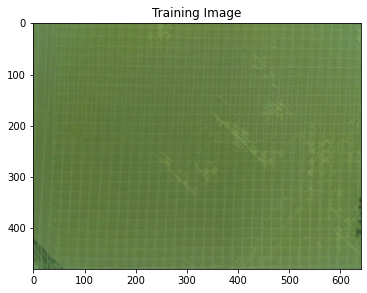

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


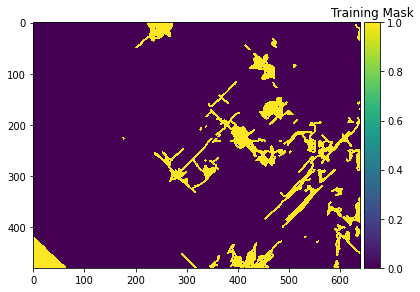

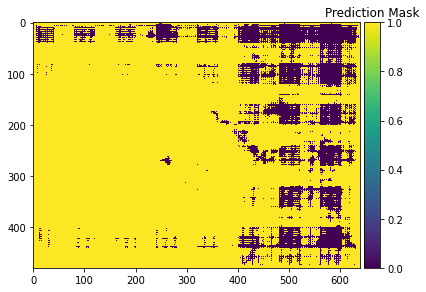

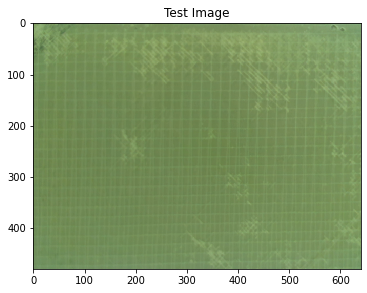

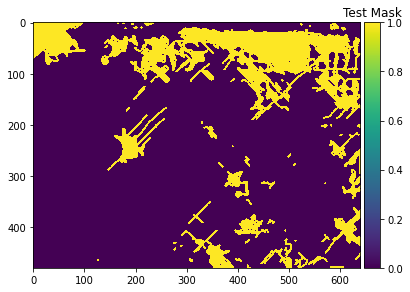

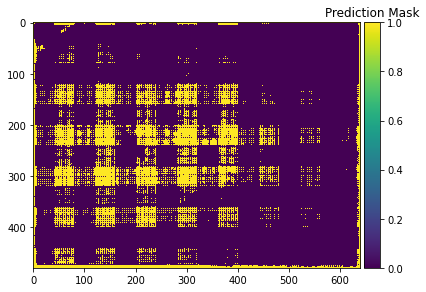

In [ ]:
np.random.seed = 42

idx = float(random.randint(0, len(X_train)))
Y_train = Y_train.astype(np.uint8)

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 ################
preds_train_t = (preds_train > .2).astype(np.uint8)
print("//////////////////")
print(preds_train.max())
print("//////////////////")

###################

preds_val_t = (preds_val > .2).astype(np.uint8)


preds_test_t = (preds_test > .2).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))

#########################################################

imshow(X_train[ix])
plt.title("Training Image")
plt.show()
############################################
imshow(np.squeeze(Y_train[ix]))
plt.title("Training Mask")
plt.show()
###############################################
imshow(np.squeeze(preds_train_t[ix]))
plt.title("Prediction Mask")
plt.show()

##############################################


# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.title("Test Image")
plt.show()
#################################################
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.title("Test Mask")
plt.show()
##################################################
imshow(np.squeeze(preds_val_t[ix]))
plt.title("Prediction Mask")
plt.show()

#################################################

In [ ]:
import tensorflow as tf
import os
import numpy as np
import random

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

IMG_WIDTH = 640
IMG_HEIGHT = 480
IMG_CHANNELS = 3

seed = 42
np.random.seed = seed

#######################################
## Getting and APPARENTLY unscrambling data
#######################################

# Importing paths
TRAIN_PATH_RAW = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML/uNet_models/Version 2.0/train_data/Images'
TRAIN_PATH_MASK = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML/uNet_models/Version 2.0/train_data/Masks'

TEST_PATH = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML/uNet_models/Version 2.0/test_data/Images'

# Listing Directories
train_raw_list = os.listdir(TRAIN_PATH_RAW)
#print(train_raw_list)
train_mask_list = os.listdir(TRAIN_PATH_MASK)
#print(train_mask_list)

test_list = os.listdir(TEST_PATH)

######################################

# For SOME REASON, the indeces are now scrambled. Need to reconnect the matching ones.
blank_train_raw_img_list = []
blank_train_mask_img_list = []

# Initilizing Counters
raw_image = 0
mask_image = 0

while len(train_raw_list) > 0:
  if (train_raw_list[raw_image][-8:-1] == train_mask_list[mask_image][-8:-1]):

      # train_raw_list corrections
      blank_train_raw_img_list.append(train_raw_list[raw_image])
      train_raw_list.pop(raw_image)

      # train_marked_list corrections
      blank_train_mask_img_list.append(train_mask_list[mask_image])
      train_mask_list.pop(mask_image)

  # Resetting mask list index
  mask_image+=1
  if mask_image > (len(train_raw_list)-1):
    mask_image = 0

# Checking Data
error_count = 0

for image in range(0, len(blank_train_raw_img_list)):
  if blank_train_raw_img_list[image][-8:-1] != blank_train_mask_img_list[image][-8:-1]:
    error_count+=1
    print(blank_train_raw_img_list[image])
    print(blank_train_mask_img_list[image])

print("Errors Found during descramble:", error_count)
print(blank_train_raw_img_list)
print(blank_train_mask_img_list)

############################################
## Redefining original lists
############################################

train_raw_list = blank_train_raw_img_list
train_mask_list = blank_train_mask_img_list

'''
############################################
## Plotting to check the data
############################################

image = random.randint(0, len(train_raw_list))

print("/////////////////////////////////////////////////////")
print("Image:", image)
print("Raw Image:", train_raw_list[image])
print("Masked Image:", train_mask_list[image])
print("/////////////////////////////////////////////////////")
print("\n")

train_rand_img = os.path.join(TRAIN_PATH_RAW, train_raw_list[image])
train_mask_img = os.path.join(TRAIN_PATH_MASK, train_mask_list[image])

train_rand_img = Image.open(train_rand_img)
train_rand_img_arr = np.asarray(train_rand_img)

train_mask_img = Image.open(train_mask_img)
train_mask_img_arr = np.asarray(train_mask_img)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

# Plot the input image
axs[0].imshow(train_rand_img_arr)
axs[0].set_title("Rand image")

# Plot the truthy mask
axs[1].imshow(train_mask_img_arr)
axs[1].set_title("Mask")
'''

#############################

# Blank TRAIN images
X_train = np.zeros((len(train_raw_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_mask_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

# Enumerating on blank TRAIN images
for n in range(0, len(train_raw_list)):
  img = imread(os.path.join(TRAIN_PATH_RAW, train_raw_list[n]))[:,:,:IMG_CHANNELS]
  X_train[n] = img

  mask = imread(os.path.join(TRAIN_PATH_MASK, train_mask_list[n]))[:,:,1]
  mask = np.stack((mask,), axis=-1) # Aligning Dimensions
  Y_train[n] = mask

# Blank TEST Images
X_test = np.zeros((len(test_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Enumerating on blank TEST images
for n in range(0, len(test_list)):
  img = imread(os.path.join(TEST_PATH, test_list[n]))[:,:,:IMG_CHANNELS]
  X_test[n] = img

Errors Found during descramble: 0
['raw_far_sample_data_2.png', 'raw_far_sample_data_1.png', 'raw_test_5.png', 'raw_test_1.png', 'raw_far_sample_data_3.png', 'raw_test_4.png', 'raw_test_7.png', 'raw_test_2.png', 'raw_test_3.png']
['marked_far_sample_data_2.png', 'marked_far_sample_data_1.png', 'marked_test_5.png', 'marked_test_1.png', 'marked_far_sample_data_3.png', 'marked_test_4.png', 'marked_test_7.png', 'marked_test_2.png', 'marked_test_3.png']


# .CSV Creation

In [ ]:
'''
This code is meant to generate
the needed data lists for the
.csv ML individual test files, and write the
.csv files. Fills the Image_Data Folder.
'''
# For data list creation
import os
from PIL import Image

# For .csv file writing
import csv

# Directories
raw_rand_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Raw_Randomized_Images'
marked_rand_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Marked_Randomized_Images'
csv_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Image_Data'

image_cnt = 0

# Randomized img index selection
# Loops thru all images
for image in range(0, len(os.listdir(raw_rand_dir))):

  image_cnt += 1
  print(f'\nThis is image {image_cnt}')

  print('The image names are as follows:')

  # Selecting samples from folder
  raw_image_list = os.listdir(raw_rand_dir)
  raw_image = raw_image_list[image]
  print(f'     The raw image is {raw_image}')

  marked_image_list = os.listdir(marked_rand_dir)
  marked_image = marked_image_list[image]
  print(f'     The marked image is {marked_image}')

  # Making sample loads ready
  raw_img_path = os.path.join(raw_rand_dir, raw_image)
  marked_img_path = os.path.join(marked_rand_dir, marked_image)

  ##################
  # Exactracting needed values from images
  ##################

  # Converting marked image into flattened
  # list of RGB values.
  marked_img = Image.open(marked_img_path, 'r')
  marked_pix_val = list(marked_img.getdata())

  # Converting marked image into flattened
  # list of RGB values.
  raw_img = Image.open(raw_img_path, 'r')
  raw_pix_val = list(raw_img.getdata())

  ###################
  # Forming Data List
  ###################

  # Forming Blank Data list for .csv file
  data_list = [[0,0,0,0,0,0]]
  for index in range(1,len(marked_pix_val)):
    data_list.append([0,0,0,0,0,0])

  # Updating Flattened Index Values in data_list
  # Placing X and Y Coordinates
  j = -1
  index = 0
  for Y in range(0,int(len(data_list)/640)):
    j += 1
    i = -1
    for X in range(0,int(len(data_list)/480)):
      i += 1
      index = i + j*640
      data_list[index][0] = X
      data_list[index][1] = Y

  #####################
  # Raw Data RGB Extraction and Application
  #####################

  # Updating R,G,B values in data_list
  i = -1
  for index in raw_pix_val:
    i += 1
    data_list[i][2] = raw_pix_val[i][0]
    data_list[i][3] = raw_pix_val[i][1]
    data_list[i][4] = raw_pix_val[i][2]

  ######### Label Extraction and Application via Marked Images

  # Updating labels in data_list
  i = -1
  for R,G,B in marked_pix_val:
    i+=1
    if R >= 254:
      data_list[i][5] = 1 # True Defect
    else:
      data_list[i][5] = 0 # False Defect

  # UI Display
  print(f'The data_list is:\n     {len(data_list)} spaces long') # length check
  check = len(data_list) == len(raw_pix_val)
  print(f'Is the length of the data = to the no. of pixels? \n   {check}')
  print("Here is what the data lists look like:\n   ", data_list[0:3]) # List check

  #########################################################
  # Writing Data Files
  #########################################################

  header = ['X', 'Y', 'R', 'G', "B", "label"]
  data = data_list

  # Getting File base name
  ## Removing .png ending from image name
  image_name = list(raw_image) # Casting string to list
  image_name_list = [] # making blank list

  image_name_list.append(image_name[4:-5]) # pulling desired letters
  base_name = ''.join(image_name_list[0]) # making word
  base_name = base_name + ".csv"

  # Creating File Name
  image_csv = os.path.join(csv_dir, base_name)

  # Opening file in write mode
  f = open(image_csv, 'w')

  writer = csv.writer(f)

  # Writing Header
  writer.writerow(header)

  # Writing the Data Table
  writer.writerows(data)

  # Notification
  print(".csv file written")

  f.close()


# Legacy


In [ ]:
import os # For file pathing
import tensorflow
from tensorflow.keras.layers import Conv2D,\
	MaxPool2D, Conv2DTranspose, Input, Activation,\
	Concatenate, CenterCrop
from tensorflow.keras import Model
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import schedules, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model # for plotting model strucutre
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt # For visualization


'''
	U-NET CONFIGURATION
'''
# BEST practice to put all definitions in one spot
def configuration():
	''' Get configuration. '''

	return dict(
    ## Dataset split
		data_train_prc = 80, # 0-80%
		data_val_prc = 90, # 10%
		data_test_prc = 100, # 10%
    ##
		num_filters_start = 64, # number of FEATURE MAPS in the beginning
		num_unet_blocks = 3, # Number of U-NET BLOCKS
		num_filters_end = 3, # number of feature maps in the end
		input_width = 100, # image width
		input_height = 100, # image height
		mask_width = 60, # output image width
		mask_height = 60, # output image height
		input_dim = 3, # 3D image/ RGB image
		optimizer = Adam, ## chosen optimizer. from KERAS
		loss = SparseCategoricalCrossentropy, ## chosen. from KERAS.
		initializer = HeNormal(), ## chosen. from KERAS.
		batch_size = 50, # batch of 50 PIXELS
		buffer_size = 50, # ???
		num_epochs = 25, # number of times train data
		metrics = ['accuracy'],
    ### ************************************
		dataset_path = os.path.join(os.getcwd(), 'data'),
    ### ***********************************
		class_weights = tensorflow.constant([1.0, 1.0, 2.0]), # help with unbalanced data sets ##########
		validation_sub_splits = 5, # for validation
    #######3
		lr_schedule_percentages = [0.2, 0.5, 0.8], # % of training at which the learning thresholds below are used
		lr_schedule_values = [3e-4, 1e-4, 1e-5, 1e-6], # learning thresholds.
		lr_schedule_class = schedules.PiecewiseConstantDecay ## chosen. From KERAS. Ensures that the learning rate is set to a
    # certain value after a certain amount of time.
	)


'''
	U-NET BUILDING BLOCKS
'''
# UNETS built from CONTRACTING PATH made from CONVOLUTIONAL BLOCKS,
# and EXPANSIVE PATH built from UPSAMPLING BLOCKS

# The output of each CONVOLUTIONAL BLOCK connected to each UPSAMPLING BLOCK
# via SKIP CONNECTION ???

def conv_block(x, filters, last_block):
	'''
		U-Net convolutional block.
		Used for downsampling in the contracting path.
	'''
  # Each made of 2 3x3 convolutional blocks. He config is used because ReLu activation is used
  # MAX POOLING is used unless it is the LAST CONVOLUTION BLOCK.

	config = configuration() # pulling configuration parameters

	# First Conv segment
	x = Conv2D(filters, (3, 3),\
		kernel_initializer=config.get("initializer"))(x)
	x = Activation("relu")(x)

	# Second Conv segment
	x = Conv2D(filters, (3, 3),\
		kernel_initializer=config.get("initializer"))(x)
	x = Activation("relu")(x)

	# Keep Conv output for skip input. SKIP CONNECTION DATA
	skip_input = x

	# Apply pooling if not last block. MAX POOLING to downsample.
	if not last_block:
		x = MaxPool2D((2, 2), strides=(2,2))(x)

  # x = processed tensor. skip_input = skip data. EVEN used in the LAST layer,
  # just WILL NOT USE THE skip_input in the LAST LAYER.
	return x, skip_input


  # EAch convolutional block perform feature learning at their level of hierarchy.
  # The number of filters for each convolutional block doubles per layer.
  # starting number = 64 ->  128, 256, etc.

################################################

def contracting_path(x):
	'''
		U-Net contracting path.
		Initializes multiple convolutional blocks for
		downsampling.
	'''
	config = configuration()

	# Compute the number of feature map filters per block
	num_filters = [compute_number_of_filters(index)\
			for index in range(config.get("num_unet_blocks"))]

	# Create container for the skip input Tensors
	skip_inputs = []

	# Pass input x through all convolutional blocks and
	# add skip input Tensor to skip_inputs if not last block
	for index, block_num_filters in enumerate(num_filters):

		last_block = index == len(num_filters)-1
		x, skip_input = conv_block(x, block_num_filters,\
			last_block)

  # If NOT the last block, adding a skip input (skip connection data) to the skip inputs container
		if not last_block:
			skip_inputs.append(skip_input)

	return x, skip_inputs

###############################################
def upconv_block(x, filters, skip_input, last_block = False):
	'''
		U-Net upsampling block.
		Used for upsampling in the expansive path.
	'''

	config = configuration()

	# Perform upsampling
	x = Conv2DTranspose(filters//2, (2, 2), strides=(2, 2),\
		kernel_initializer=config.get("initializer"))(x)
	shp = x.shape

	# Crop the skip input, keep the center
	cropped_skip_input = CenterCrop(height = x.shape[1],\
		width = x.shape[2])(skip_input)

	# Concatenate skip input with x
	concat_input = Concatenate(axis=-1)([cropped_skip_input, x])

	# First Conv segment
	x = Conv2D(filters//2, (3, 3),
		kernel_initializer=config.get("initializer"))(concat_input)
	x = Activation("relu")(x)

	# Second Conv segment
	x = Conv2D(filters//2, (3, 3),
		kernel_initializer=config.get("initializer"))(x)
	x = Activation("relu")(x)

	# Prepare output if last block
	if last_block:
		x = Conv2D(config.get("num_filters_end"), (1, 1),
			kernel_initializer=config.get("initializer"))(x)

	return x

#################################################

def expansive_path(x, skip_inputs):
	'''
		U-Net expansive path.
		Initializes multiple upsampling blocks for upsampling.
	'''
	num_filters = [compute_number_of_filters(index)\
			for index in range(configuration()\
				.get("num_unet_blocks")-1, 0, -1)]

	skip_max_index = len(skip_inputs) - 1

	for index, block_num_filters in enumerate(num_filters):
		skip_index = skip_max_index - index
		last_block = index == len(num_filters)-1
		x = upconv_block(x, block_num_filters,\
			skip_inputs[skip_index], last_block)

	return x


def build_unet():
	''' Construct U-Net. '''
	config = configuration()
	input_shape = (config.get("input_height"),\
		config.get("input_width"), config.get("input_dim"))

	# Construct input layer
	input_data = Input(shape=input_shape)

	# Construct Contracting path
	contracted_data, skip_inputs = contracting_path(input_data)

	# Construct Expansive path
	expanded_data = expansive_path(contracted_data, skip_inputs)

	# Define model
	model = Model(input_data, expanded_data, name="U-Net")

	return model


def compute_number_of_filters(block_number):
	'''
		Compute the number of filters for a specific
		U-Net block given its position in the contracting path.
	'''
	return configuration().get("num_filters_start") * (2 ** block_number)


'''
	U-NET TRAINING PROCESS BUILDING BLOCKS
'''

def init_model(steps_per_epoch):
	'''
		Initialize a U-Net model.
	'''
	config = configuration()
	model = build_unet()

	# Retrieve compilation input
	loss_init = config.get("loss")(from_logits=True)
	metrics = config.get("metrics")
	num_epochs = config.get("num_epochs")

	# Construct LR schedule
	boundaries = [int(num_epochs * percentage * steps_per_epoch)\
		for percentage in config.get("lr_schedule_percentages")]
	lr_schedule = config.get("lr_schedule_class")(boundaries, config.get("lr_schedule_values"))

	# Init optimizer
	optimizer_init = config.get("optimizer")(learning_rate = lr_schedule)

	# Compile the model
	model.compile(loss=loss_init, optimizer=optimizer_init, metrics=metrics)

	# Plot the model
	plot_model(model, to_file="unet.png")

	# Print model summary
	model.summary()

	return model


def load_dataset():
	'''	Return dataset with info. '''
	config = configuration()

	# Retrieve percentages
	train = config.get("data_train_prc")
	val = config.get("data_val_prc")
	test = config.get("data_test_prc")

	# Redefine splits over full dataset
	splits = [f'train[:{train}%]+test[:{train}%]',\
		f'train[{train}%:{val}%]+test[{train}%:{val}%]',\
		f'train[{val}%:{test}%]+test[{val}%:{test}%]']

	# Return data
	return tfds.load('oxford_iiit_pet:3.*.*', split=splits, data_dir=configuration()\
		.get("dataset_path"), with_info=True)


def normalize_sample(input_image, input_mask):
	''' Normalize input image and mask class. '''
	# Cast image to float32 and divide by 255
	input_image = tensorflow.cast(input_image, tensorflow.float32) / 255.0

  # Bring classes into range [0, 2]
	input_mask -= 1

	return input_image, input_mask


def preprocess_sample(data_sample):
	''' Resize and normalize dataset samples. '''
	config = configuration()

	# Resize image
	input_image = tensorflow.image.resize(data_sample['image'],\
  	(config.get("input_width"), config.get("input_height")))

  # Resize mask
	input_mask = tensorflow.image.resize(data_sample['segmentation_mask'],\
  	(config.get("mask_width"), config.get("mask_height")))

  # Normalize input image and mask
	input_image, input_mask = normalize_sample(input_image, input_mask)

	return input_image, input_mask


def data_augmentation(inputs, labels):
	''' Perform data augmentation. '''
	# Use the same seed for deterministic randomness over both inputs and labels.
	seed = 36

  # Feed data through layers
	inputs = tensorflow.image.random_flip_left_right(inputs, seed=seed)
	inputs = tensorflow.image.random_flip_up_down(inputs, seed=seed)
	labels = tensorflow.image.random_flip_left_right(labels, seed=seed)
	labels = tensorflow.image.random_flip_up_down(labels, seed=seed)

	return inputs, labels


def compute_sample_weights(image, mask):
	''' Compute sample weights for the image given class. '''
	# Compute relative weight of class
	class_weights = configuration().get("class_weights")
	class_weights = class_weights/tensorflow.reduce_sum(class_weights)

  # Compute same-shaped Tensor as mask with sample weights per
  # mask element.
	sample_weights = tensorflow.gather(class_weights,indices=\
  	tensorflow.cast(mask, tensorflow.int32))

	return image, mask, sample_weights


def preprocess_dataset(data, dataset_type, dataset_info):
	''' Fully preprocess dataset given dataset type. '''
	config = configuration()
	batch_size = config.get("batch_size")
	buffer_size = config.get("buffer_size")

	# Preprocess data given dataset type.
	if dataset_type == "train" or dataset_type == "val":
		# 1. Perform preprocessing
		# 2. Cache dataset for improved performance
		# 3. Shuffle dataset
		# 4. Generate batches
		# 5. Repeat
		# 6. Perform data augmentation
		# 7. Add sample weights
		# 8. Prefetch new data before it being necessary.
		return (data
				    .map(preprocess_sample)
				    .cache()
				    .shuffle(buffer_size)
				    .batch(batch_size)
				    .repeat()
				    .map(data_augmentation)
				    .map(compute_sample_weights)
				    .prefetch(buffer_size=tensorflow.data.AUTOTUNE))
	else:
		# 1. Perform preprocessing
		# 2. Generate batches
		return (data
						.map(preprocess_sample)
						.batch(batch_size))


def training_callbacks():
	''' Retrieve initialized callbacks for model.fit '''
	return [
		TensorBoard(
		  log_dir=os.path.join(os.getcwd(), "unet_logs"),
		  histogram_freq=1,
		  write_images=True
		)
	]


def probs_to_mask(probs):
	''' Convert Softmax output into mask. '''
	pred_mask = tensorflow.argmax(probs, axis=2)
	return pred_mask


def generate_plot(img_input, mask_truth, mask_probs):
	''' Generate a plot of input, truthy mask and probability mask. '''
	fig, axs = plt.subplots(1, 4)
	fig.set_size_inches(16, 6)

	# Plot the input image
	axs[0].imshow(img_input)
	axs[0].set_title("Input image")

	# Plot the truthy mask
	#axs[1].imshow(mask_truth)
	#axs[1].set_title("True mask")

	# Plot the predicted mask
	predicted_mask = probs_to_mask(mask_probs)
	axs[2].imshow(predicted_mask)
	axs[2].set_title("Predicted mask")

	# Plot the overlay
	config = configuration()
	img_input_resized = tensorflow.image.resize(img_input, (config.get("mask_width"), config.get("mask_height")))
	axs[3].imshow(img_input_resized)
	axs[3].imshow(predicted_mask, alpha=0.5)
	axs[3].set_title("Overlay")

	# Show the plot
	plt.show()


def main():
	''' Run full training procedure. '''

	# Load config
	config = configuration()
	batch_size = config.get("batch_size")
	validation_sub_splits = config.get("validation_sub_splits")
	num_epochs = config.get("num_epochs")

	# Load data
	(training_data, validation_data, testing_data), info = load_dataset()

	# Make training data ready for model.fit and model.evaluate
	train_batches = preprocess_dataset(training_data, "train", info)
	val_batches = preprocess_dataset(validation_data, "val", info)
	test_batches = preprocess_dataset(testing_data, "test", info)

	# Compute data-dependent variables
	train_num_samples = tensorflow.data.experimental.cardinality(training_data).numpy()
	val_num_samples = tensorflow.data.experimental.cardinality(validation_data).numpy()
	steps_per_epoch = train_num_samples // batch_size
	val_steps_per_epoch = val_num_samples // batch_size // validation_sub_splits

	# Initialize model
	model = init_model(steps_per_epoch)

	# Train the model
	model.fit(train_batches, epochs=num_epochs, batch_size=batch_size,\
		steps_per_epoch=steps_per_epoch, verbose=1,
		validation_steps=val_steps_per_epoch, callbacks=training_callbacks(),\
		validation_data=val_batches)

	# Test the model
	score = model.evaluate(test_batches, verbose=0)
	print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

	# Take first batch from the test images and plot them
	for images, masks in test_batches.take(1):

		# Generate prediction for each image
		predicted_masks = model.predict(images)

		# Plot each image and masks in batch
		for index, (image, mask) in enumerate(zip(images, masks)):
			generate_plot(image, mask, predicted_masks[index])
			if index > 4:
				break


if __name__ == '__main__':
	main()

In [ ]:
'''
This code is meant to generate
the needed data lists for the
.csv ML individual test files, and write the
.csv files. Fills the Image_Data Folder.
'''
# For data list creation
import os
from PIL import Image

# For .csv file writing
import csv

# Directories
raw_rand_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Raw_Randomized_Images'
marked_rand_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Marked_Randomized_Images'
csv_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Image_Data/gray_data'

image_cnt = 0

# Randomized img index selection
# Loops thru all images
for image in range(0, len(os.listdir(raw_rand_dir))):

  image_cnt += 1
  print(f'\nThis is image {image_cnt}')

  # Selecting samples from folder
  raw_image_list = os.listdir(raw_rand_dir)
  raw_image = raw_image_list[image]
  print(f'     The raw image is {raw_image}')

  marked_image_list = os.listdir(marked_rand_dir)
  marked_image = marked_image_list[image]
  print(f'     The marked image is {marked_image}')

  # Making sample loads ready
  raw_img_path = os.path.join(raw_rand_dir, raw_image)
  marked_img_path = os.path.join(marked_rand_dir, marked_image)

  ##################
  # Exactracting needed values from images
  ##################

  # Converting marked image into flattened
  # list of RGB values.
  marked_img = Image.open(marked_img_path, 'r')
  marked_pix_val = list(marked_img.getdata())

  # Converting marked image into flattened
  # list of RGB values.
  raw_img = Image.open(raw_img_path, 'r')
  raw_pix_val = list(raw_img.getdata())

  ###################
  # Forming Data List
  ###################

  # Forming Blank Data list for .csv file
  data_list = [[0,0,0,0,0]]
  for index in range(1,len(marked_pix_val)):
    data_list.append([0,0,0,0,0])

  # Updating Flattened Index Values in data_list
  # Placing X and Y Coordinates

  for x in range(0,int(len(data_list))):
    data_list[x][0] = x

  #####################
  # Raw Data RGB Extraction and Application
  #####################

  # Updating R,G,B values in data_list
  i = -1
  for index in raw_pix_val:
    i += 1
    data_list[i][1] = raw_pix_val[i][0]
    data_list[i][2] = raw_pix_val[i][1]
    data_list[i][3] = raw_pix_val[i][2]

  ######### Label Extraction and Application via Marked Images

  # Updating labels in data_list
  i = -1
  for R,G,B in marked_pix_val:
    i+=1
    if R >= 254:
      data_list[i][4] = 1 # True Defect
    else:
      data_list[i][4] = 0 # False Defect

  # UI Display
  print(f'The data_list is:\n     {len(data_list)} spaces long') # length check
  check = len(data_list) == len(raw_pix_val)
  print(f'Is the length of the data = to the no. of pixels? \n   {check}')
  print("Here is what the data lists look like:\n   ", data_list[0:3]) # List check

  '''
  Code meant to convert RGB values to
  Grayscale Values
  '''

  print('\nThe RGB values are: \n', data_list[0:3]) # For Reference

  # Empty List
  grayscale = []

  # Looping thru list of RGB pixel values
  # and converting to grayscale
  for index in range(0, len(data_list)):
    data = [0,0,0]
    data[0] = index
    data[1] = int(round(0.299*data_list[index][1] + 0.587*data_list[index][2] + 0.114*data_list[index][3], 0))
    data[2] = data_list[index][4]
    grayscale.append(data)

  print('\nThe grayscale values are:\n', grayscale[0:3]) # For Reference

  #########################################################
  # Writing Training Data to Training File
  #########################################################

  header = ['index', 'grayscale', "label"]
  data = grayscale

  # Getting File base name
  ## Removing .png ending from image name
  image_name = list(raw_image) # Casting string to list
  image_name_list = [] # making blank list

  image_name_list.append(image_name[4:-5]) # pulling desired letters
  base_name = ''.join(image_name_list[0]) # making word
  base_name = base_name + ".csv"

  # Creating File Name
  image_csv = os.path.join(csv_dir, base_name)

  # Opening file in write mode
  f = open(image_csv, 'w')

  writer = csv.writer(f)

  # Writing Header
  writer.writerow(header)

  # Writing the Data Table
  writer.writerows(data)

  # Notification
  print(".csv file written")

  f.close()

In [ ]:
'''
Training File
Video: https://www.youtube.com/watch?v=fiTgEi8WnFc

https://github.com/nikhilroxtomar/Cell-Nuclei-Segmentation-in-TensorFlow-2.0/blob/main/UNET/train.py

https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-u-net-for-image-segmentation-with-tensorflow-and-keras.md

ResNet???
'''

In [ ]:
'''
Code meant to TEST Neural Network
'''
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np

# .csv File Directory
csv_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Image_Data/gray_data'

# Setting split
split_percent = 0.70
split = split_percent*len(os.listdir(csv_dir))

# Test length is leftover files.
test_len = (len(os.listdir(csv_dir)) - int(split))

# Initializing variables
csv_list = os.listdir(csv_dir)

# Index to start pulling .csv data from the back
i = -1
eval_num = 1

# Looping thru test samples to test each one
for data in range(0, test_len):

  csv_file_path = os.path.join(csv_dir, csv_list[i])
  test_df = pd.read_csv(csv_file_path)
  i -= 1

  # Stacking columns b/c
  # presumably they're codependent
  test_x = np.column_stack((test_df.index.values, test_df.grayscale.values))

  print("This is test #:", eval_num)
  print("The image is:", csv_list[i])
  eval_num += 1

  # Running Test
  reconstructed_model.evaluate(test_x, test_df.label.values)

print("Tests Complete!")


In [ ]:
for layer in reconstructed_model_gray.layers:
    weights_gray1 = layer.get_weights() # list of numpy arrays
for layer in reconstructed_model_XYRGB.layers:
    weights_XYRGB1 = layer.get_weights() # list of numpy arrays
for layer in reconstructed_model_RGB.layers:
    weights_RGB1 = layer.get_weights() # list of numpy arrays

print("1st LAYER")

print("THE Gray 1st 5 weights are:")
print(weights_gray1[0][0:5])
print("\nTHE XYRGB 1st 5 weights are:")
print(weights_XYRGB1[0][0:5])
print("\nTHE RGB 1st 5 weights are:")
print(weights_RGB1[0][0:5])

weights_gray2 = reconstructed_model_gray.get_weights()
print(f"\n GRAY MODEL \n {weights_gray2[0][0:5][0]})")
weights_XYRGB2 = reconstructed_model_XYRGB.get_weights()
print(f"\n XYRGB MODEL \n {weights_XYRGB2[0][0:5][0]})")
weights_RGB2 = reconstructed_model_RGB.get_weights()
print(f"\n RGB MODEL \n {weights_RGB2[0][0:5][0]})")

In [ ]:
'''
Importing Gray and various stacked Neural Networks.
For SEQUENTIAL MODEL.
'''

from tensorflow import keras

# Loading Grayscale Model
reconstructed_model_gray = keras.models.load_model('/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Models/Model_grayscale')

# Loading 8x8 model X,Y,R,G,B
reconstructed_model_XYRGB = keras.models.load_model('/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Models/8x8_Model_XY_RGB')

# Loading 8x8 model R,G,B
reconstructed_model_RGB = keras.models.load_model('/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Models/8x8_Model_RGB')

In [ ]:
model_8x8.save('/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Models/Model_grayscale')

In [ ]:
"""
Training Network R Values
"""
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

# Training Data Path
train_path = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Train_Data/train_grayscale/gray_train.csv'

# Reading the .csv file
train_df = pd.read_csv(train_path)


# Neural Network Layers
model_8x8 = keras.Sequential([
	keras.layers.Dense(128, input_shape = (2,), activation='relu'),
	keras.layers.Dropout(0.4),
	keras.layers.Dense(64, activation='relu'),
	keras.layers.Dropout(0.4),
	keras.layers.Dense(64, activation='relu'),
	keras.layers.Dense(2, activation='sigmoid')])

# Nerual Network Compiler
model_8x8.compile(optimizer='adam',
	          loss=keras.losses.SparseCategoricalCrossentropy(),
	          metrics=['accuracy'])

# Stacking the RGB columns b/c
# presumably they're codependent
x = np.column_stack((train_df.index.values, train_df.grayscale.values))

# Batch size = PIXEL COUNT
model_8x8.fit(x, train_df.label.values, batch_size=64, epochs=1)

In [ ]:
'''
This code is meant to check the dimensions of the
training data set and compare with the values beneath epoch
'''

# Training Data Path
train_path = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Train_Data/8x8_train.csv'

# Reading the .csv file
train_df = pd.read_csv(train_path)

# Training Data dimensions
print(len(train_df))

# Image Dimensions
column_count = 640
row_count = 480

# Backing out the number of images
no_rows = len(train_df)/column_count
print("The number of rows in the train data is:", no_rows)
image_count = no_rows/row_count
print("The number of images is:", image_count)

In [ ]:
'''
Code meant to concatenate .csv files
to create training data set.
Files found in the Train_Data Folder.
Files is impossible to preview and will
cutoff data in excel due to length.
'''
import pandas as pd
import numpy as np
import os
import csv

# .csv File directory
csv_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Image_Data_8x8'

# Initializing variables
csv_list = os.listdir(csv_dir)
pixel_list = []
img_index = 0

# .csv header
header = ['X', 'Y', 'R', 'G', "B", "label"]

########################################################
# Creating Training Data List
########################################################

# Looping thru 70% of data
split_percent = 0.70
split = split_percent*len(os.listdir(csv_dir))
test_len = len(os.listdir(csv_dir)) - int(split)

for data in range(0, int(split)):

  # Opening the .csv file
  csv_file_path = os.path.join(csv_dir, csv_list[data])
  df = pd.read_csv(csv_file_path, header = 0)

  i = 0 # initializing pixel counter

  # Copying pixel value data
  for row in range(0, len(df)):
    pixel = [0,0,0,0,0,0]
    j = -1 # initializing header index counter

    for pix_val in range(0,len(header)):
      j += 1
      pixel[j] = df.loc[i, header[j]]

    # Appending to main pixel data list
    pixel_list.append(pixel)
    i += 1

  print(len(pixel_list))

#########################################################
# Writing Training Data to Training File
#########################################################

# Test Data Directory
train_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Train_Data'

# File Name
train_name = "8x8_train.csv"

# Creating File Name
train_csv = os.path.join(train_dir, train_name)

# Opening file in write mode
f = open(train_csv, 'w')

writer = csv.writer(f)

# Writing Header
writer.writerow(header)

# Writing the Data Table
writer.writerows(pixel_list)

# Notification
print(".csv file copied. The test data can be found in the Train_Data folder.")

f.close()

In [ ]:
'''
Code meant to backup the Training data
set made below. Found in ML_Data_Backups.

This code is meant to backup and clear out
the Image data .csv files made below.
Found in the ML_Data_Backups folder.
'''

import os
import shutil
from datetime import datetime

############ Moving Old Folders

# Getting Folder Paths
csv_path = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Train_Data'
backup_dst_path = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/ML_Data_Backups'

# Moving Folder to Backup Folder
shutil.move(csv_path, backup_dst_path)

############ Renaming the Moved Folders

# Getting Date and time
dt_string = datetime.now()
dt_string = dt_string.strftime("%H:%M:%S %b %d %Y")

# Printing time stamp on folder
csv_folder_name = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/ML_Data_Backups/Train_Data'
new_csv_folder_name = str(dt_string) + " " + "Train_Data"
new_csv_folder_name = os.path.join(backup_dst_path, new_csv_folder_name)
os.rename(csv_folder_name, new_csv_folder_name)

#####################################
# Making new folder to replace the old one
#####################################

# Directory
csv_folder_name = "Train_Data"

# File path the File will be made in
parent_folder = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data'

# Combined path of new folder
new_csv_folder = os.path.join(parent_folder, csv_folder_name)

# Making new folder
os.mkdir(new_csv_folder)

print("The folder '% s' has been cleared. \nThe old one can be found in ML_Data_Backups with it's timestamp.\n" % new_csv_folder)

In [ ]:
# For showing raw and marked image pairs.

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

rand_dir = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Raw_Randomized_Images'
mask_dir = "/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Masks"

mask_image_list = os.listdir(mask_dir)
rand_image_list = os.listdir(rand_dir)

image = 22

print("/////////////////////////////////////////////////////")
print("Image:", image)
print("Raw Image:", rand_image_list[image])
print("Masked Image:", mask_image_list[image])
print("/////////////////////////////////////////////////////")
print("\n")

############################
rand_image = rand_image_list[image]
mask_image = mask_image_list[image]

rand_img_path = os.path.join(rand_dir, rand_image)
mask_img_path = os.path.join(mask_dir, mask_image)

rand_img = rand_img_path
mask_img = mask_img_path

rand_img = Image.open(rand_img)
rand_img_arr = np.asarray(rand_img)

mask_img = Image.open(mask_img)
mask_img_arr = np.asarray(mask_img)

###########################
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

# Plot the input image
axs[0].imshow(rand_img_arr)
axs[0].set_title("Rand image")

# Plot the truthy mask
axs[1].imshow(mask_img_arr)
axs[1].set_title("Mask")

In [ ]:
'''
This code is meant to backup and clear out
the Image data .csv files made below.
Found in the ML_Data_Backups folder.
'''

import os
import shutil
from datetime import datetime

############ Moving Old Folders

# Getting Folder Paths
csv_path = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/Image_Data'
backup_dst_path = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/ML_Data_Backups'

# Moving Folder to Backup Folder
shutil.move(csv_path, backup_dst_path)

############ Renaming the Moved Folders

# Getting Date and time
dt_string = datetime.now()
dt_string = dt_string.strftime("%H:%M:%S %b %d %Y")

# Printing time stamp on folder
csv_folder_name = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data/ML_Data_Backups/Image_Data'
new_csv_folder_name = str(dt_string) + " " + "Image_Data"
new_csv_folder_name = os.path.join(backup_dst_path, new_csv_folder_name)
os.rename(csv_folder_name, new_csv_folder_name)

#####################################
# Making new folder to replace the old one
#####################################

# Directory
csv_folder_name = "Image_Data"

# File path the File will be made in
parent_folder = '/content/drive/MyDrive/Glass_Fibre_CV_ML/ML_Data'

# Combined path of new folder
new_csv_folder = os.path.join(parent_folder, csv_folder_name)

# Making new folder
os.mkdir(new_csv_folder)

print("The folder '% s' has been cleared. \nThe old one can be found in ML_Data_Backups with it's timestamp.\n" % new_csv_folder)

In [ ]:
'''
Code meant to extract desired images from the randomized image list
to be put in a selective test data set.
'''
####################
# Listing Image indecis and names
####################
raw_save_path = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Raw_Randomized_Images'
randomized_save_path = '/content/drive/MyDrive/Glass_Fibre_CV_ML/Randomized_Images/Marked_Randomized_Images'

dir = os.listdir(raw_save_path)
img_list = []
i = 0

for img in dir:
  print(f'The Image is {img}.')
  print(f"The index is: {i}. \n")
  i+=1
  img_list.append(img)